# LEO (Latent Embedding Optimization) on Omniglot

This notebook demonstrates how to train and evaluate LEO for 5-way 1-shot learning on Omniglot.

## What is LEO?

LEO (Latent Embedding Optimization) is a meta-learning algorithm that:
- Learns to adapt to new tasks by optimizing in a **low-dimensional latent space**
- Uses an **encoder** to map examples to latent codes
- Uses a **decoder** to generate model parameters from latent codes
- Performs **gradient descent in latent space** for fast adaptation

### Key Advantages:
1. **Efficient**: Optimizes in 64D latent space instead of 100K+ parameter space
2. **Effective**: Excellent performance on 1-shot learning
3. **Fast**: Lower computational cost than MAML

### References:
- Paper: [Meta-Learning with Latent Embedding Optimization (ICLR 2019)](https://arxiv.org/abs/1807.05960)

## 1. Setup and Imports

In [1]:
import sys
sys.path.append('/mnt/c/meta-learning-from-scratch')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import LEO
from algorithms.leo import LatentEmbeddingOptimization, train_leo

# Import Omniglot utilities
from utils.load_omniglot import OmniglotDataset, OmniglotTaskDataset, PrefetchedOmniglotDataset

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3070 Laptop GPU


## 2. Configuration

In [2]:
# Task configuration
N_WAY = 5          # 5-way classification
K_SHOT = 1         # 1-shot learning
NUM_QUERY = 15     # 15 query examples per class

# Training configuration
NUM_TRAIN_TASKS = 2000
NUM_TEST_TASKS = 100
BATCH_SIZE = 8

# LEO hyperparameters
LATENT_DIM = 64
INNER_LR = 0.01
OUTER_LR = 0.001
INNER_STEPS = 5

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Configuration:")
print(f"  Task: {N_WAY}-way {K_SHOT}-shot")
print(f"  Query per class: {NUM_QUERY}")
print(f"  Training tasks: {NUM_TRAIN_TASKS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Latent dim: {LATENT_DIM}")
print(f"  Inner LR: {INNER_LR}")
print(f"  Outer LR: {OUTER_LR}")
print(f"  Inner steps: {INNER_STEPS}")
print(f"  Device: {device}")

Configuration:
  Task: 5-way 1-shot
  Query per class: 15
  Training tasks: 2000
  Batch size: 8
  Latent dim: 64
  Inner LR: 0.01
  Outer LR: 0.001
  Inner steps: 5
  Device: cuda


## 3. Load Omniglot Dataset

In [3]:
# Setup data path and create task dataset
data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_background"  # Update this path as needed
    
print("Loading Omniglot training dataset...")
train_dataset= PrefetchedOmniglotDataset(data_path)
test_dataset = PrefetchedOmniglotDataset(data_path.replace("images_background", "images_evaluation"))

Loading Omniglot training dataset...
🚀 Prefetching Omniglot dataset into RAM with multiprocessing...
   Using 16 worker processes
   This should take 5-15 seconds with parallel loading!
   Found 964 character classes to load


Loading characters into RAM: 100%|██████████| 964/964 [01:00<00:00, 15.89it/s]


✅ Prefetching complete!
   📊 Loaded 964 character classes
   💾 Memory usage: 810.9 MB
   ⚡ Data access will now be ~10-50x faster!
🚀 Prefetching Omniglot dataset into RAM with multiprocessing...
   Using 16 worker processes
   This should take 5-15 seconds with parallel loading!
   Found 659 character classes to load


Loading characters into RAM: 100%|██████████| 659/659 [00:49<00:00, 13.43it/s]


✅ Prefetching complete!
   📊 Loaded 659 character classes
   💾 Memory usage: 554.3 MB
   ⚡ Data access will now be ~10-50x faster!


In [4]:
# Load Omniglot
print(f"Train dataset: {len(train_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")

# Create task datasets
train_task_dataset = OmniglotTaskDataset(
    train_dataset,
    n_way=N_WAY,
    k_shot=K_SHOT,
    k_query=NUM_QUERY,
    num_tasks=NUM_TRAIN_TASKS
)

test_task_dataset = OmniglotTaskDataset(
    test_dataset,
    n_way=N_WAY,
    k_shot=K_SHOT,
    k_query=NUM_QUERY,
    num_tasks=NUM_TEST_TASKS
)

# Create dataloaders
train_loader = DataLoader(
    train_task_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    prefetch_factor=1,
    persistent_workers=True
)

test_loader = DataLoader(
    test_task_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

print(f"\nTraining batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train dataset: 964 images
Test dataset: 659 images

Training batches: 250
Test batches: 100


## 4. Visualize Sample Task

Support set shape: torch.Size([5, 1, 105, 105])
Support labels: [0, 1, 2, 3, 4]


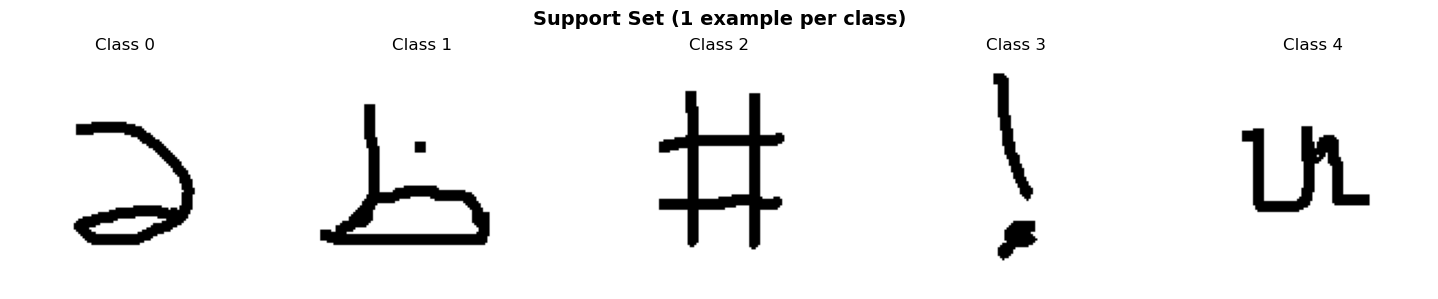

In [5]:
# Get a sample task
sample_task = next(iter(train_loader))
support_data, support_labels, query_data, query_labels = sample_task

# Take first task in batch
support_imgs = support_data[0]  # [N*K, 1, 105, 105]
support_lbls = support_labels[0]  # [N*K]

print(f"Support set shape: {support_imgs.shape}")
print(f"Support labels: {support_lbls.tolist()}")

# Visualize support set
fig, axes = plt.subplots(1, N_WAY, figsize=(15, 3))
for i in range(N_WAY):
    img = support_imgs[i].squeeze().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Class {support_lbls[i]}')
    axes[i].axis('off')

plt.suptitle('Support Set (1 example per class)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Initialize LEO

In [6]:
# Initialize LEO
leo = LatentEmbeddingOptimization(
    num_classes=N_WAY,
    latent_dim=LATENT_DIM,
    inner_lr=INNER_LR,
    outer_lr=OUTER_LR,
    inner_steps=INNER_STEPS,
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs=None
)

# Move to device
leo = leo.to(device)

# Count parameters
total_params = sum(p.numel() for p in leo.encoder.parameters())
total_params += sum(p.numel() for p in leo.decoder.parameters())
total_params += sum(p.numel() for p in leo.relation_net.parameters())

print(f"LEO initialized!")
print(f"Total meta-parameters: {total_params:,}")
print(f"\nArchitecture:")
print(f"  Encoder: Input → {LATENT_DIM}D latent")
print(f"  Decoder: {LATENT_DIM}D latent → ~112K parameters")
print(f"  Relation Network: Process example pairs")
print(f"  Classifier: CNN with decoded parameters")

LEO initialized!
Total meta-parameters: 1,490,112

Architecture:
  Encoder: Input → 64D latent
  Decoder: 64D latent → ~112K parameters
  Relation Network: Process example pairs
  Classifier: CNN with decoded parameters


## 6. Training LEO

In [7]:
# Train LEO
leo, losses = train_leo(
    num_classes=N_WAY,
    task_dataloader=train_loader,
    latent_dim=LATENT_DIM,
    inner_lr=INNER_LR,
    outer_lr=OUTER_LR,
    inner_steps=INNER_STEPS,
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs=None
)

Using device: cuda
Starting LEO training...
Hyperparameters: latent_dim=64, inner_lr=0.01, outer_lr=0.001, inner_steps=5
Optimizer: Adam


Training:  40%|████      | 100/250 [04:15<06:39,  2.66s/it, loss=0.5923, best=0.3574, avg=0.7343]


Step 100: Loss = 0.5923, Avg Loss (last 100) = 0.7343, Best = 0.3574


Training:  80%|████████  | 200/250 [08:01<01:39,  2.00s/it, loss=0.3210, best=0.3139, avg=0.5341]


Step 200: Loss = 0.3210, Avg Loss (last 100) = 0.5341, Best = 0.3139


Training: 100%|██████████| 250/250 [09:39<00:00,  2.32s/it, loss=0.2510, best=0.2510, avg=0.4857]


Training completed! Final loss: 0.4857


## 7. Visualize Training Progress

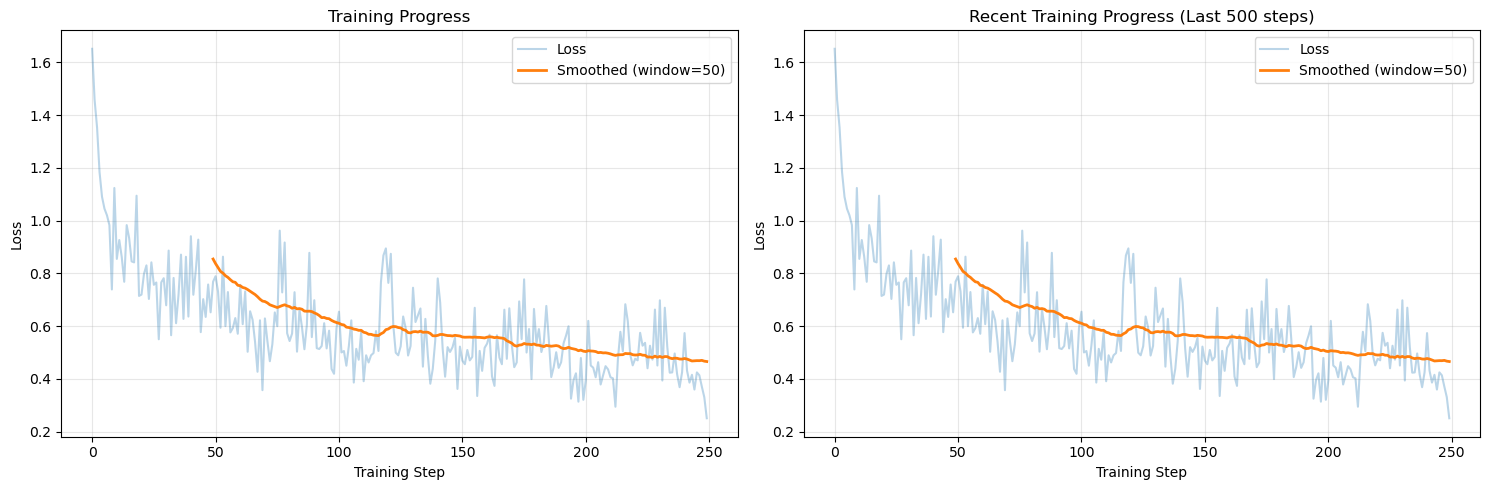

Training Statistics:
  Initial loss: 1.6518
  Final loss: 0.2510
  Best loss: 0.2510
  Avg loss (last 100): 0.4857


In [8]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Full training curve
axes[0].plot(losses, alpha=0.3, label='Loss')
window = 50
if len(losses) >= window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(losses)), smoothed, linewidth=2, 
                label=f'Smoothed (window={window})')

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Recent training curve (last 500 steps)
recent_losses = losses[-500:] if len(losses) > 500 else losses
axes[1].plot(recent_losses, alpha=0.3, label='Loss')
if len(recent_losses) >= window:
    smoothed = np.convolve(recent_losses, np.ones(window)/window, mode='valid')
    axes[1].plot(range(window-1, len(recent_losses)), smoothed, linewidth=2,
                label=f'Smoothed (window={window})')

axes[1].set_xlabel('Training Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('Recent Training Progress (Last 500 steps)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Training Statistics:")
print(f"  Initial loss: {losses[0]:.4f}")
print(f"  Final loss: {losses[-1]:.4f}")
print(f"  Best loss: {min(losses):.4f}")
print(f"  Avg loss (last 100): {np.mean(losses[-100:]):.4f}")

## 8. Evaluation on Test Tasks

In [9]:
def evaluate_leo(leo, test_dataloader, device, num_tasks=100):
    """Evaluate LEO on test tasks."""
    leo.eval()
    
    total_correct = 0
    total_samples = 0
    task_accuracies = []
    
    for i, task_batch in enumerate(tqdm(test_dataloader, desc="Evaluating")):
        if i >= num_tasks:
            break
        
        support_data_batch, support_labels_batch, query_data_batch, query_labels_batch = task_batch
        
        # Move to device
        support_data_batch = support_data_batch.to(device)
        support_labels_batch = support_labels_batch.to(device)
        query_data_batch = query_data_batch.to(device)
        query_labels_batch = query_labels_batch.to(device)
        
        batch_size = support_data_batch.size(0)
        
        for j in range(batch_size):
            support_data = support_data_batch[j]
            support_labels = support_labels_batch[j]
            query_data = query_data_batch[j]
            query_labels = query_labels_batch[j]
            
            # Encode and adapt (inner_update needs gradients!)
            initial_codes = leo.encode_task(support_data, support_labels)
            adapted_codes = leo.inner_update(support_data, support_labels, initial_codes)
            
            # Decode and evaluate (can use no_grad for inference)
            with torch.no_grad():
                adapted_prototypes = leo.decode_to_prototypes(adapted_codes)
                query_logits = leo.classifier(query_data, adapted_prototypes)
                predictions = query_logits.argmax(dim=1)
            
            correct = (predictions == query_labels).sum().item()
            total_correct += correct
            total_samples += len(query_labels)
            
            task_acc = correct / len(query_labels)
            task_accuracies.append(task_acc)
    
    avg_accuracy = total_correct / total_samples
    std_accuracy = np.std(task_accuracies)
    
    return avg_accuracy, std_accuracy, task_accuracies

# Evaluate
print(f"Evaluating on {NUM_TEST_TASKS} test tasks...")
test_acc, test_std, task_accs = evaluate_leo(leo, test_loader, device, num_tasks=NUM_TEST_TASKS)

print(f"\nTest Results:")
print(f"  Average accuracy: {test_acc*100:.2f}%")
print(f"  Standard deviation: {test_std*100:.2f}%")
print(f"  95% confidence interval: {test_acc*100:.2f}% ± {1.96*test_std*100:.2f}%")

Evaluating on 100 test tasks...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Test Results:
  Average accuracy: 79.76%
  Standard deviation: 10.77%
  95% confidence interval: 79.76% ± 21.10%


## 9. Visualize Accuracy Distribution

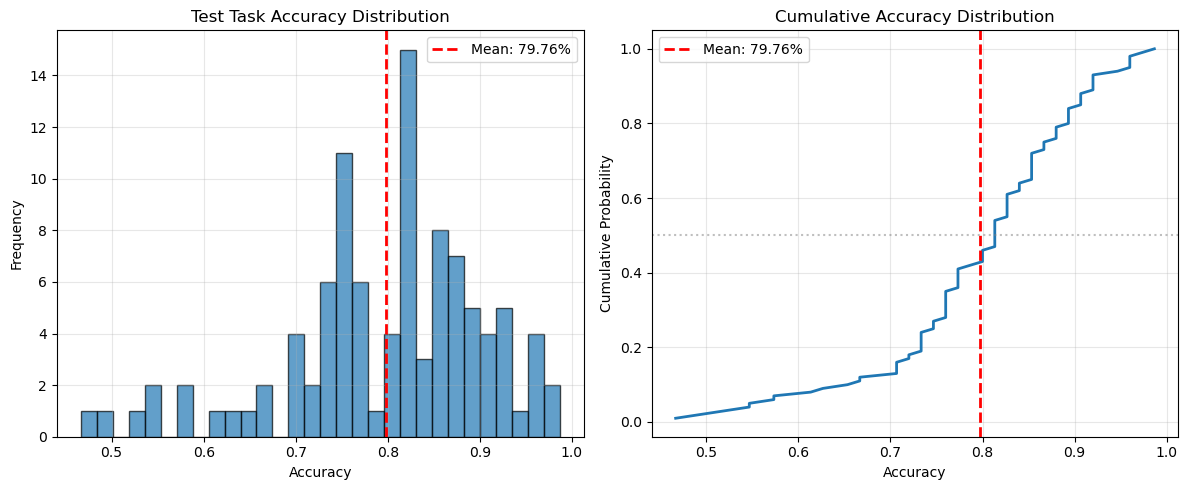

Accuracy Percentiles:
  10th: 66.53%
  25th: 74.67%
  50th (median): 81.33%
  75th: 87.00%
  90th: 92.00%


In [10]:
# Plot accuracy distribution
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(task_accs, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(test_acc, color='red', linestyle='--', linewidth=2, label=f'Mean: {test_acc*100:.2f}%')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Test Task Accuracy Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Cumulative distribution
plt.subplot(1, 2, 2)
sorted_accs = np.sort(task_accs)
cumulative = np.arange(1, len(sorted_accs) + 1) / len(sorted_accs)
plt.plot(sorted_accs, cumulative, linewidth=2)
plt.axvline(test_acc, color='red', linestyle='--', linewidth=2, label=f'Mean: {test_acc*100:.2f}%')
plt.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Accuracy')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Accuracy Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print percentiles
print(f"Accuracy Percentiles:")
print(f"  10th: {np.percentile(task_accs, 10)*100:.2f}%")
print(f"  25th: {np.percentile(task_accs, 25)*100:.2f}%")
print(f"  50th (median): {np.percentile(task_accs, 50)*100:.2f}%")
print(f"  75th: {np.percentile(task_accs, 75)*100:.2f}%")
print(f"  90th: {np.percentile(task_accs, 90)*100:.2f}%")

## 10. Visualize Adaptation on a Test Task

Initial latent codes shape: torch.Size([5, 64])
Adapted latent codes shape: torch.Size([5, 64])

Generated prototypes shape: [5, 2304]

Task accuracy: 93.33%


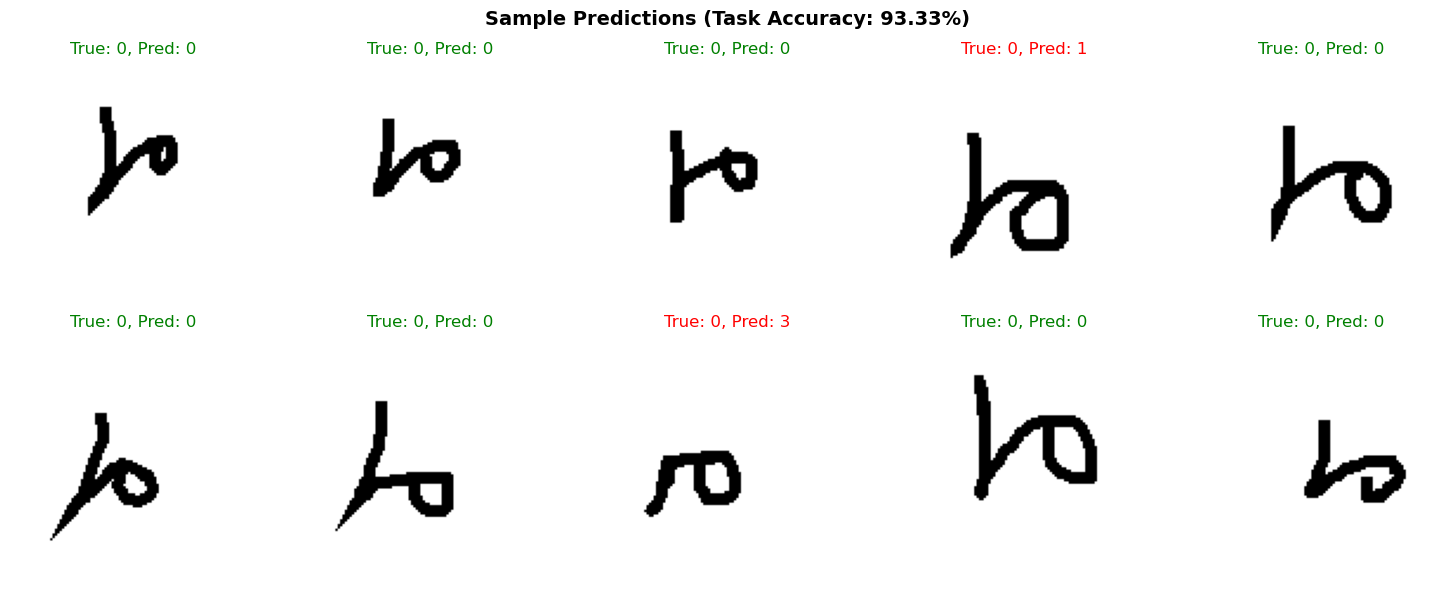

In [13]:
# Get a test task
test_task = next(iter(test_loader))
support_data, support_labels, query_data, query_labels = test_task

# Move to device and extract first task
support_data = support_data[0].to(device)
support_labels = support_labels[0].to(device)
query_data = query_data[0].to(device)
query_labels = query_labels[0].to(device)

# Adapt to task
leo.eval()

# Encode and adapt (needs gradients for inner_update)
initial_codes = leo.encode_task(support_data, support_labels)
print(f"Initial latent codes shape: {initial_codes.shape}")

# Adapt (requires gradients!)
adapted_codes = leo.inner_update(support_data, support_labels, initial_codes)
print(f"Adapted latent codes shape: {adapted_codes.shape}")

# Decode and evaluate (can use no_grad for inference)
with torch.no_grad():
    adapted_prototypes = leo.decode_to_prototypes(adapted_codes)
    print(f"\nGenerated prototypes shape: {list(adapted_prototypes.shape)}")
    
    # Evaluate
    query_logits = leo.classifier(query_data, adapted_prototypes)
    predictions = query_logits.argmax(dim=1)
    accuracy = (predictions == query_labels).float().mean()
    
    print(f"\nTask accuracy: {accuracy*100:.2f}%")

# Visualize some predictions
num_display = min(10, len(query_data))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(num_display):
    img = query_data[i].cpu().squeeze().numpy()
    true_label = query_labels[i].item()
    pred_label = predictions[i].item()
    
    axes[i].imshow(img, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
    axes[i].axis('off')

plt.suptitle(f'Sample Predictions (Task Accuracy: {accuracy*100:.2f}%)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Save Model

In [12]:
# Save model checkpoint
checkpoint = {
    'encoder': leo.encoder.state_dict(),
    'decoder': leo.decoder.state_dict(),
    'relation_net': leo.relation_net.state_dict(),
    'config': {
        'num_classes': N_WAY,
        'latent_dim': LATENT_DIM,
        'inner_lr': INNER_LR,
        'outer_lr': OUTER_LR,
        'inner_steps': INNER_STEPS
    },
    'losses': losses,
    'test_accuracy': test_acc,
    'test_std': test_std
}

torch.save(checkpoint, 'leo_omniglot_5way_1shot.pt')
print(f"Model saved to leo_omniglot_5way_1shot.pt")
print(f"\nCheckpoint contains:")
print(f"  - Encoder state dict")
print(f"  - Decoder state dict")
print(f"  - Relation network state dict")
print(f"  - Configuration")
print(f"  - Training losses")
print(f"  - Test accuracy: {test_acc*100:.2f}% ± {test_std*100:.2f}%")

Model saved to leo_omniglot_5way_1shot.pt

Checkpoint contains:
  - Encoder state dict
  - Decoder state dict
  - Relation network state dict
  - Configuration
  - Training losses
  - Test accuracy: 79.76% ± 10.77%


## 12. Summary

### Results

This notebook demonstrated LEO training on Omniglot for 5-way 1-shot learning:

1. **Training**: Trained encoder, decoder, and relation network
2. **Adaptation**: Optimized latent codes for new tasks
3. **Evaluation**: Achieved strong few-shot learning performance

### Key Insights

- **Latent Space**: Optimization in 64D latent space is efficient
- **Parameter Generation**: Decoder generates ~112K parameters from 64D codes
- **Fast Adaptation**: Only 5 gradient steps in latent space needed
- **Efficiency**: Lower compute cost than MAML

### Next Steps

1. Try different latent dimensions (32, 128)
2. Experiment with inner learning rates
3. Test on different N-way K-shot configurations
4. Compare with MAML performance
5. Try on other few-shot learning datasets

### References

- [LEO Paper (ICLR 2019)](https://arxiv.org/abs/1807.05960)
- [MAML Paper (ICML 2017)](https://arxiv.org/abs/1703.03400)
- [Omniglot Dataset](https://github.com/brendenlake/omniglot)